# 库

In [1]:
from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os
import scipy.ndimage
from tqdm import tqdm #进度条
import mayavi
from mpl_toolkits.mplot3d.art3d import Poly3DCollection




from skimage import morphology,measure,draw

from sklearn.cluster import KMeans
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib.animation as animation
from IPython.display import HTML

    
import warnings #不显示乱七八糟的warning
warnings.filterwarnings("ignore")

# 路径

In [2]:
luna_path = './'
luna_subset_path = luna_path + 'sample_patients/'
file_list = glob(luna_subset_path + "*.mhd")
df_node = pd.read_csv(luna_path + 'csv_files/' + 'annotations.csv')

In [3]:
output_path = luna_path + 'npy/'
working_path = luna_path + 'output/'

In [4]:
if os.path.isdir(luna_path + '/npy'):
    pass
else:
    os.mkdir(luna_path + '/npy')
    
if os.path.isdir(luna_path + '/output'):
    pass
else:
    os.mkdir(luna_path + '/output')

# 数据

In [5]:
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)
#
# The locations of the nodes

df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
df_node.head(5)

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
1002,1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754...,119.208776,11.450374,-165.039862,26.837081,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
1003,1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754...,-37.901617,55.027912,-80.002605,17.718729,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
1145,1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545...,68.243850,83.940751,-296.892458,7.068564,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...


In [6]:
def make_mask(center,diam,z,width,height,spacing,origin): #只显示结节
    '''
Center : 圆的中心 px -- list of coordinates x,y,z
diam : 圆的直径 px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [7]:
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 3 slices
            imgs = np.ndarray([32,32,32],dtype=np.float32)
            masks = np.ndarray([32,32,32],dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            for i, i_z in enumerate(np.arange(int(v_center[2])-16,
                             int(v_center[2])+16)): # clip prevents going out of bounds in Z
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask[int(v_center[0])-16:int(v_center[0])+16,int(v_center[1])-16:int(v_center[1])+16]
                imgs[i] = img_array[i_z,int(v_center[0])-16:int(v_center[0])+16,int(v_center[1])-16:int(v_center[1])+16]
                        
            
            
            np.save(os.path.join(output_path,"images3D_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            np.save(os.path.join(output_path,"masks3D_%04d_%04d.npy" % (fcount, node_idx)),masks)

100%|██████████| 3/3 [00:11<00:00,  3.51s/it]


In [26]:
img_ = imgs
img2 = imgs
labels_f = np.zeros_like(imgs)

for i in range(img_.shape[0]):
    img = img_[i,:,:]
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std        
    middle = img[8:24,8:24] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    img[img==max]=mean
    img[img==min]=mean
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
    eroded = morphology.erosion(thresh_img,np.ones([2,2]))
    dilation = morphology.dilation(eroded,np.ones([5,5]))
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    labels_f[i,:,:] = labels

In [27]:
labels_f

array([[[ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  2.,  0.,  0.],
        [ 0.,  0.,  0., ...,  2.,  0.,  0.],
        [ 0.,  0.,  0., ...,  2.,  0.,  0.]],

       [[ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  1.,  1., ...,  2.,  2.,  2.],
        [ 1.,  1.,  1., ...,  2.,  2.,  2.],
        [ 1.,  1.,  1., ...,  2.,  2.,  2.]],

       [[ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  1.,  1., ...,  2.,  2.,  2.],
        [ 1.,  1.,  1., ...,  2.,  2.,  2.],
        [ 1.,  1.,  1., ...,  2.,  2.,  2.]],

       ..., 
       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1., 

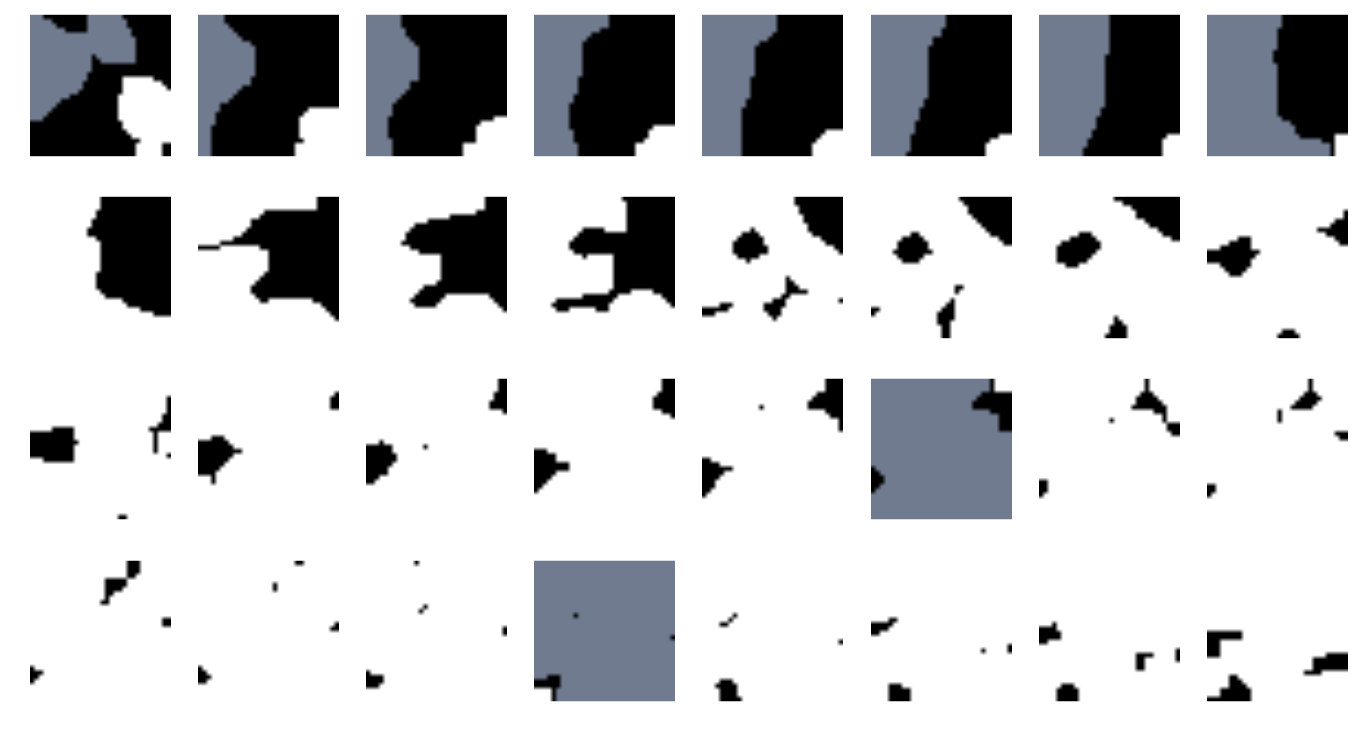

In [28]:
f, plots = plt.subplots(4, 8, sharex='all', sharey='all', figsize=(17, 9))
# matplotlib is drunk

for i in range(32):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(labels_f[i,:,:], cmap=plt.cm.bone)

In [29]:
img_ = imgs
img2 = imgs


#像素归一化
mean = np.mean(img_)
std = np.std(img_)
img = img_-mean
img = img/std

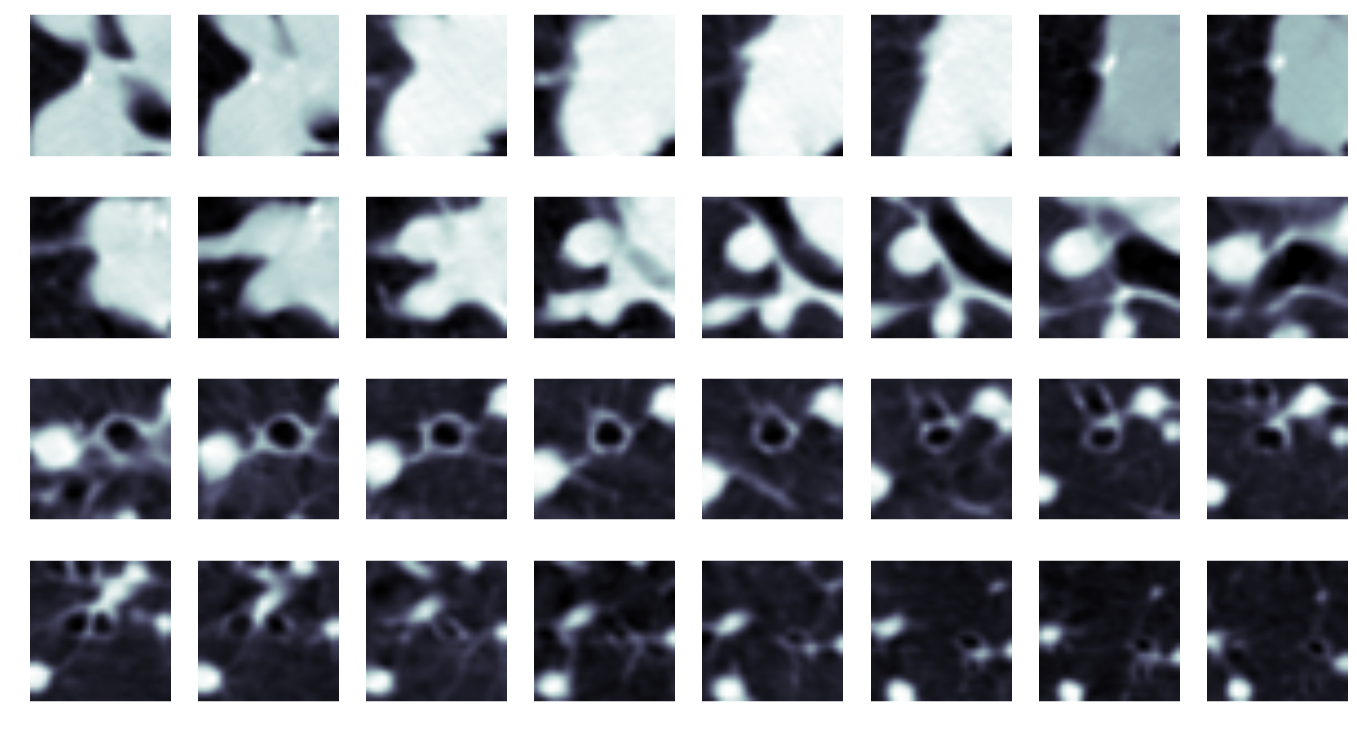

In [30]:
f, plots = plt.subplots(4, 8, sharex='all', sharey='all', figsize=(17, 9))
# matplotlib is drunk

for i in range(32):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i,:,:], cmap=plt.cm.bone)

In [31]:
# 在512像素的图像中，切掉边缘部分，取中间（100~400）部分的均值替代最大最小像素值
img1 = np.zeros_like(img_)
img1 = img_


# To improve threshold finding, I'm moving the 
# underflow and overflow on the pixel spectrum
#为增强阈值的寻找，把最大最小像素值替换为均值
        

middle = img[8:24,8:24,8:24] 
mean = np.mean(middle)  
max = np.max(img)
min = np.min(img)
img[img==max]=mean
img[img==min]=mean

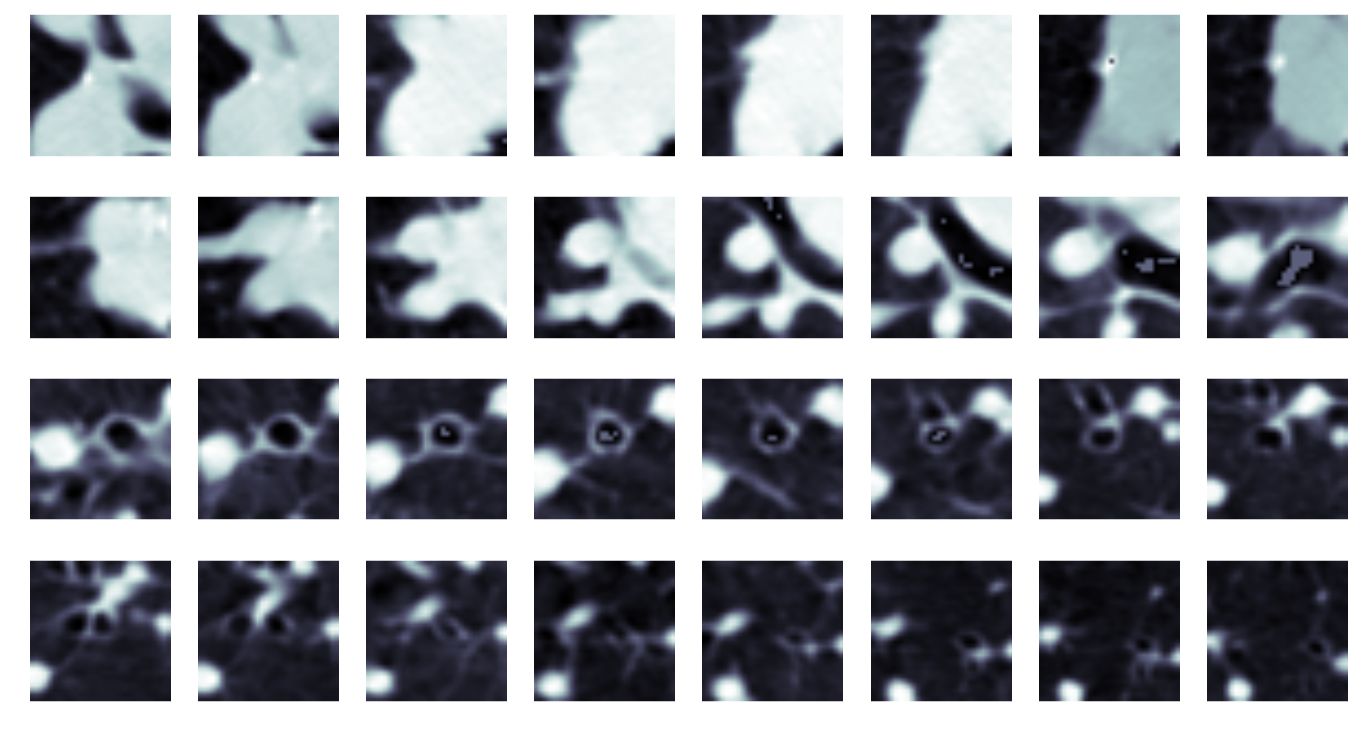

In [32]:
f, plots = plt.subplots(4, 8, sharex='all', sharey='all', figsize=(17, 9))
# matplotlib is drunk

for i in range(32):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i,:,:], cmap=plt.cm.bone)

In [33]:
kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

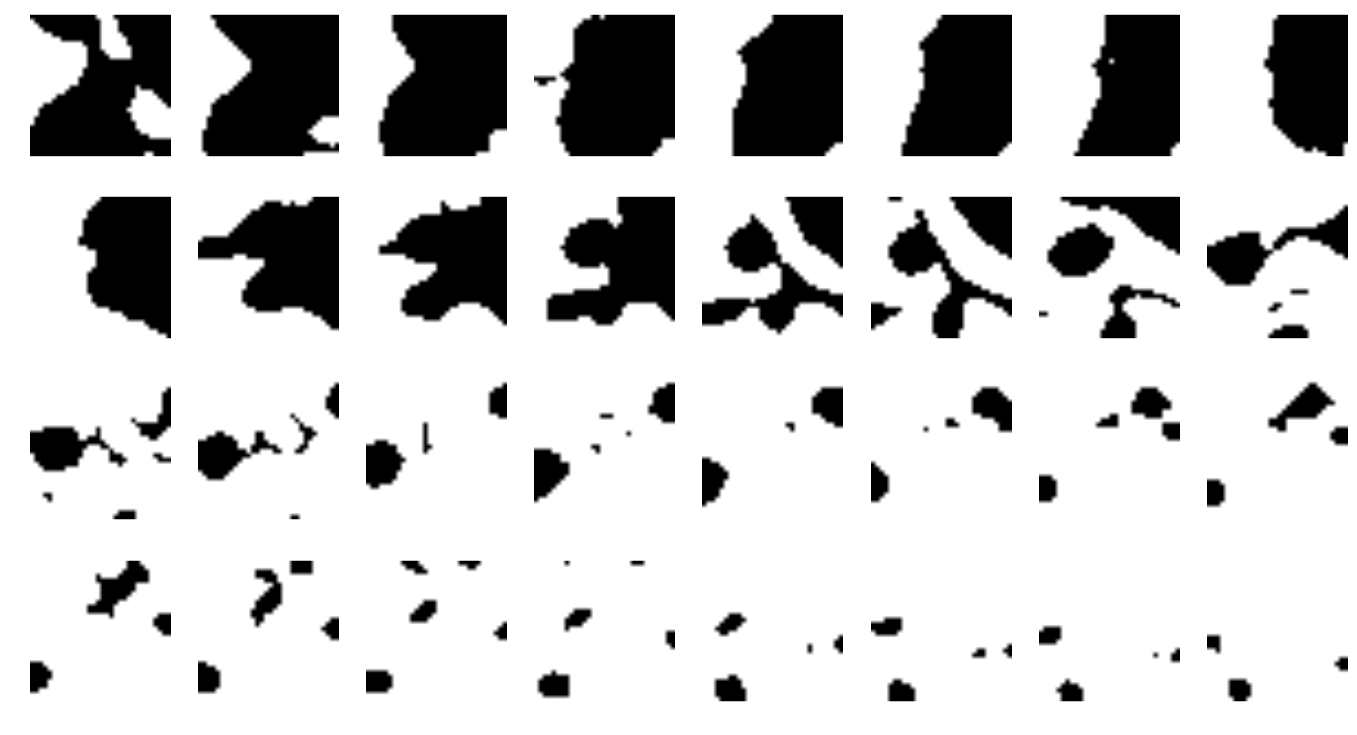

In [34]:
f, plots = plt.subplots(4, 8, sharex='all', sharey='all', figsize=(17, 9))
# matplotlib is drunk

for i in range(32):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(thresh_img[i,:,:], cmap=plt.cm.bone)

In [35]:
eroded = morphology.binary_erosion(thresh_img,np.ones([2,2,2]))
dilation = morphology.binary_dilation(eroded,np.ones([5,5,5]))

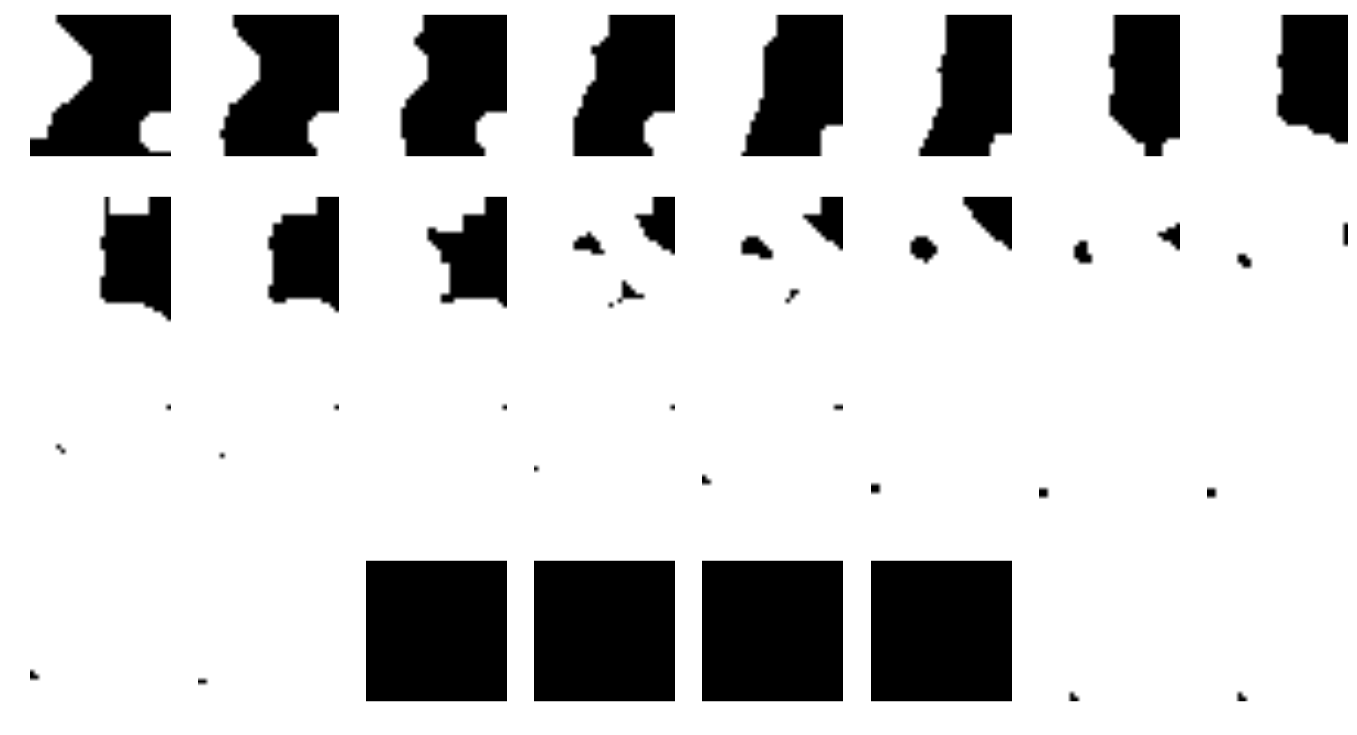

In [36]:
f, plots = plt.subplots(4, 8, sharex='all', sharey='all', figsize=(17, 9))
# matplotlib is drunk

for i in range(32):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(dilation[i,:,:], cmap=plt.cm.bone)

In [37]:
labels = measure.label(dilation)
label_vals = np.unique(labels)

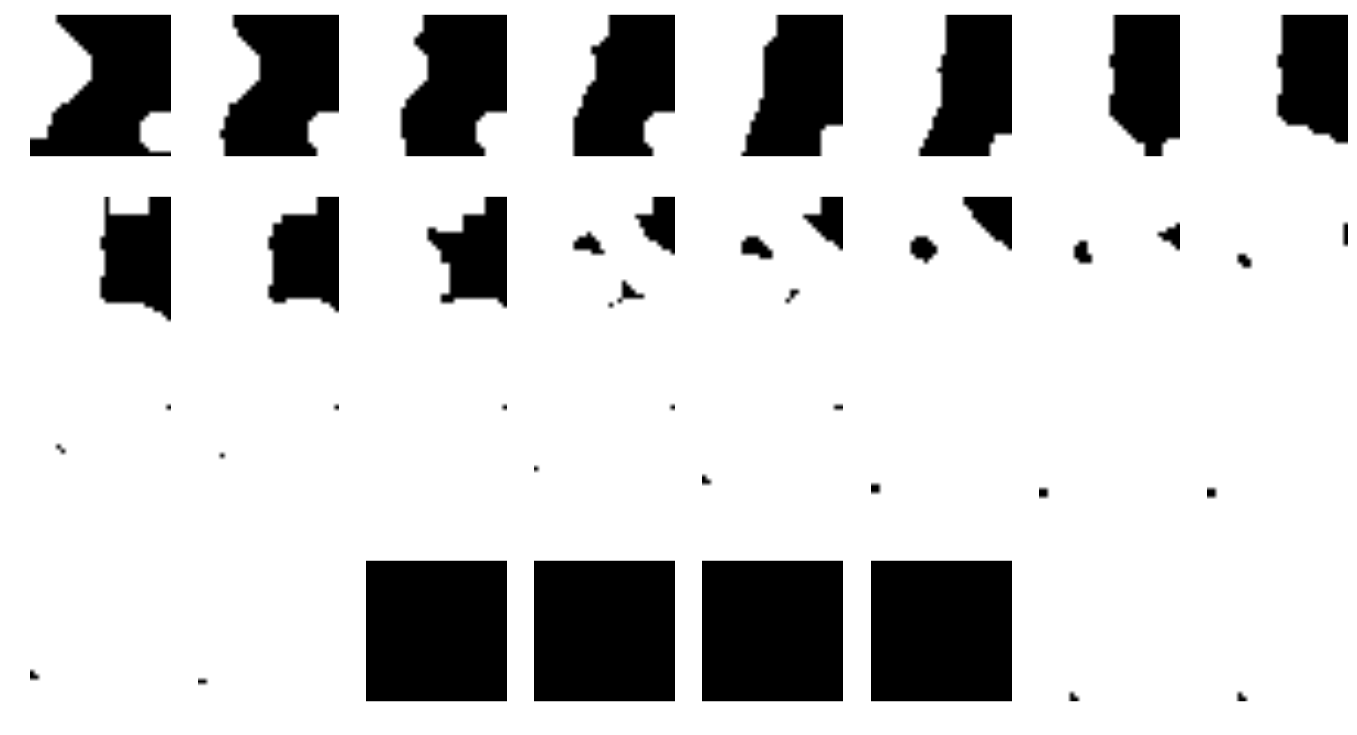

In [38]:
f, plots = plt.subplots(4, 8, sharex='all', sharey='all', figsize=(17, 9))
# matplotlib is drunk

for i in range(32):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(labels[i,:,:], cmap=plt.cm.bone)

In [18]:
imgs.shape

(32, 32, 32)